<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/regularizedRSNN_0213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports -----

import torch, torch.nn as nn
import snntorch as snn
import numpy as np

import random

In [ ]:
#Random seeds -----

random.seed(211)
torch.manual_seed(211)

In [ ]:
#MNIST -----

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#Define variables
batch_size = 128
data_path = '/data/mnist'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Define transformations
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#Define training and test sets
mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

#Create DataLoaders
trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last = True) #drop_last to remove last (incongruent) batch
testloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last = True)

In [ ]:
#Initialize membrane time constant distribution -----

tau_mem = 20e-3
dist_shape = 3
time_step = 0.5e-3

def clip_tc(x):
    clipped_tc = x.clamp_(0.7165, 0.995)
    return clipped_tc

def init_tc():
    dist_gamma = np.random.gamma(dist_shape, tau_mem / 3, 100)
    dist_beta = torch.from_numpy(np.exp(-time_step / dist_gamma))
    clipped_beta = clip_tc(dist_beta)
    return clipped_beta

In [ ]:
#Model architecture -----

from snntorch import surrogate

#Size parameters
num_inputs = 28*28
num_hidden = 100
num_outputs = 10

#Network parameters
het_tau = init_tc()
hom_tau = 0.9753
num_steps = 25

#Optimization mechanism
spike_grad = surrogate.fast_sigmoid()

#Model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.RLeaky(beta = het_tau, linear_features = num_hidden, learn_beta = True, spike_grad = spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta = hom_tau, spike_grad = spike_grad)

    def forward(self, x):

        #Initialize parameters
        spk1, mem1 = self.lif1.init_rleaky() #init_rleaky() creates a tuple [_SpikeTensor, _SpikeTensor], assigns each to mem1 and spk1
        mem2 = self.lif2.init_leaky() #init_leaky() creates a tensor _SpikeTensor 

        #Record final layer
        spk_rec = []
        mem_rec = []

        #Forward loop
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk_rec.append(spk2)
            mem_rec.append(mem2)

        #Convert final lists to tensors
        spk_rec = torch.stack(spk_rec)
        mem_rec = torch.stack(mem_rec)
        
        return spk_rec, mem_rec

net = Net().to(device)

Layer: fc1.weight | Size: torch.Size([100, 784]) | Values : Parameter containing:
tensor([[-0.0336,  0.0044, -0.0097,  ...,  0.0192, -0.0272,  0.0161],
        [ 0.0069,  0.0102, -0.0193,  ...,  0.0127, -0.0317, -0.0165],
        [ 0.0200, -0.0184, -0.0155,  ...,  0.0243, -0.0189,  0.0069],
        ...,
        [-0.0149,  0.0295, -0.0329,  ...,  0.0355,  0.0161,  0.0074],
        [-0.0285,  0.0111,  0.0275,  ...,  0.0139,  0.0228,  0.0313],
        [ 0.0087, -0.0195,  0.0018,  ..., -0.0126,  0.0340, -0.0238]],
       requires_grad=True) 

Layer: fc1.bias | Size: torch.Size([100]) | Values : Parameter containing:
tensor([-0.0276, -0.0239, -0.0224, -0.0323, -0.0249,  0.0234, -0.0133,  0.0225,
        -0.0121,  0.0259, -0.0253,  0.0199,  0.0014, -0.0106,  0.0048, -0.0080,
         0.0090, -0.0344, -0.0167,  0.0209,  0.0019, -0.0013, -0.0148,  0.0029,
         0.0230,  0.0041,  0.0220,  0.0219,  0.0269,  0.0077, -0.0222, -0.0228,
        -0.0235,  0.0221,  0.0103,  0.0339,  0.0256, -0.0356

Text(0.5, 0, 'ms')

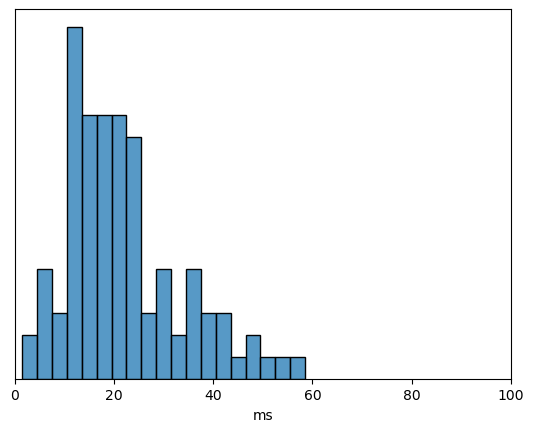

In [ ]:
#Model visualizations (pre-training) -----

import matplotlib.pyplot as plt
import seaborn as sns  

#All layers and associated parameters
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

#Membrane time constant distribution
#Define plot + parameters
tau = (-time_step / np.log(init_tc())) / 1e-3
fig, ax = plt.subplots()
tc_distribution = sns.histplot(data = tau, kde = False, ax = ax, binwidth = 3)

#Set x-axis limit and remove y-axis
ax.set_xlim(0,100)
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('ms')

In [ ]:
#Optimizer and loss function -----

import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas = (0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2)

In [ ]:
#Distance matrix -----

import scipy 

network_structure = [5, 5, 4]
distance_metric = 'euclidean'
distance_power = 1

nx = np.arange(network_structure[0])
ny = np.arange(network_structure[1])
nz = np.arange(network_structure[2])

[x,y,z] = np.meshgrid(nx,ny,nz)
coordinates = [x.ravel(),y.ravel(),z.ravel()]

euclidean_vector = scipy.spatial.distance.pdist(np.transpose(coordinates), metric=distance_metric)
euclidean = scipy.spatial.distance.squareform(euclidean_vector**distance_power)
distance_matrix = euclidean.astype('float32')

distance_matrix = torch.from_numpy(distance_matrix)

In [ ]:
#Training paradigm -----

#Training parameters
num_epochs = 10
num_steps = 25

#Regularization parameters
regu_strength = 0.1

#Initialize loss, accuracy, mean weights
loss_hist = []
acc_hist = []
feed_mean_hist = []
rec_mean_hist = []

#Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):

        #Load on CUDA (if available)
        data = data.to(device)
        targets = targets.to(device)

        #Set model to training mode
        net.train()
        outputs, _ = net(data.view(batch_size, -1))

        #Spatial + L1 regularization
        abs_weight_matrix = torch.abs(net.lif1.recurrent.weight)
        spatial_L1_loss = regu_strength * torch.sum(torch.mul(abs_weight_matrix, distance_matrix))

        #Calculate loss
        loss_val = loss_fn(outputs, targets) + spatial_L1_loss

        #Mean weights calculation
        feed_weight = torch.mean(torch.abs(net.fc1.weight))
        rec_weight = torch.mean(torch.abs(net.lif1.recurrent.weight)) 

        #Gradient calculation and weight updates
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        clip_tc(net.lif1.beta.data)

        #Store loss history
        loss_hist.append(loss_val.item())

        #Store absolute mean weight history
        feed_mean_hist.append(feed_weight.item())
        rec_mean_hist.append(rec_weight.item())

        #Prints (print every 25 iterations)
        if i % 25 == 0:
            net.eval()

            #Print training loss + mean weights
            # print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")
            # print(f"Absolute mean of feedforward weights is {feed_weight.item()}")
            # print(f"Absolute mean of recurrent weights is {rec_weight.item()}")

            #Model performance on single batch
            acc = SF.accuracy_rate(outputs, targets) #Outputs: [num_steps, batch_size, num_outputs]. Targets: [batch_size]
            acc_hist.append(acc)
            # print(f"Accuracy: {acc * 100:.2f}%\n")

Epoch 0, Iteration 0 
Train Loss: 153.05
Absolute mean of feedforward weights is 0.017896069213747978
Absolute mean of recurrent weights is 0.04985194653272629
Accuracy: 13.28%

Epoch 0, Iteration 25 
Train Loss: 85.74
Absolute mean of feedforward weights is 0.01846965216100216
Absolute mean of recurrent weights is 0.028396448120474815
Accuracy: 73.44%

Epoch 0, Iteration 50 
Train Loss: 38.77
Absolute mean of feedforward weights is 0.019006144255399704
Absolute mean of recurrent weights is 0.013082084245979786
Accuracy: 82.81%

Epoch 0, Iteration 75 
Train Loss: 10.89
Absolute mean of feedforward weights is 0.019411196932196617
Absolute mean of recurrent weights is 0.003990028984844685
Accuracy: 85.94%

Epoch 0, Iteration 100 
Train Loss: 1.81
Absolute mean of feedforward weights is 0.019791651517152786
Absolute mean of recurrent weights is 0.0010381480678915977
Accuracy: 85.16%

Epoch 0, Iteration 125 
Train Loss: 0.72
Absolute mean of feedforward weights is 0.020151490345597267
Abso

Layer: fc1.weight | Size: torch.Size([100, 784]) | Values : Parameter containing:
tensor([[-0.0336,  0.0044, -0.0097,  ...,  0.0192, -0.0272,  0.0161],
        [ 0.0069,  0.0102, -0.0193,  ...,  0.0127, -0.0317, -0.0165],
        [ 0.0200, -0.0184, -0.0155,  ...,  0.0243, -0.0189,  0.0069],
        ...,
        [-0.0149,  0.0295, -0.0329,  ...,  0.0355,  0.0161,  0.0074],
        [-0.0285,  0.0111,  0.0275,  ...,  0.0139,  0.0228,  0.0313],
        [ 0.0087, -0.0195,  0.0018,  ..., -0.0126,  0.0340, -0.0238]],
       requires_grad=True) 

Layer: fc1.bias | Size: torch.Size([100]) | Values : Parameter containing:
tensor([-0.0182,  0.0114,  0.0461, -0.1019, -0.0416,  0.0091,  0.0271, -0.0315,
        -0.0014,  0.0504, -0.0346, -0.0886, -0.0197, -0.0206, -0.0011, -0.0338,
         0.0754, -0.0659,  0.0232, -0.0767,  0.0660, -0.0131, -0.0299,  0.0664,
         0.0859,  0.0761,  0.0242, -0.0366, -0.0453,  0.0148, -0.0383, -0.0108,
         0.0621,  0.1909,  0.1903,  0.0106,  0.0615, -0.1106

Text(0.5, 0, 'ms')

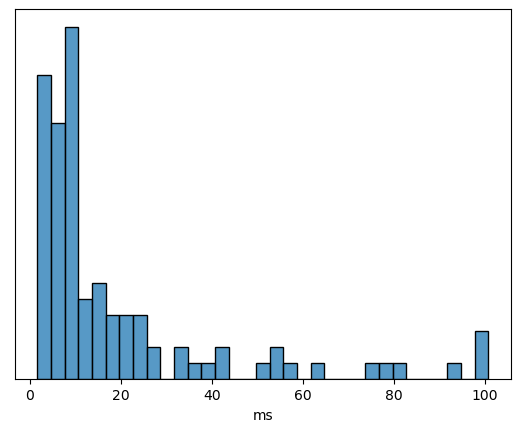

In [ ]:
#Model visualizations (post-training) -----

#All layers and associated parameters
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

#Membrane time constant distribution
#Define plot + parameters
tau = (-time_step / np.log(net.lif1.beta.data)) / 1e-3
fig, ax = plt.subplots()
tc_distribution = sns.histplot(data = tau, kde = False, ax = ax, binwidth = 3)

#Visual modifications
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('ms')

In [ ]:
#Diagnostic tests -----

from scipy.stats import pearsonr
#Test for L1 regularization
# def test_L1():
    #Visualize evolution of weights 
    #Set up a function for regu_strength saying if (condition_baseline), set regu_strength = 0 — then in the test, call both conditions

#Test for spatial regularization
def test_euclidean(x, y):
    x = torch.abs(x)
    x_array = x.detach().numpy()
    flat_x_array = x_array.flatten()
    y = torch.abs(y)
    y_array = y.detach().numpy()
    flat_y_array = y_array.flatten()
    correlation = pearsonr(flat_x_array, flat_y_array)
    return correlation

In [ ]:
test_euclidean(distance_matrix, net.lif1.recurrent.weight)

PearsonRResult(statistic=-0.20610096519982501, pvalue=2.2411190210167585e-96)

In [ ]:
# #Activity analyses -----

# import pandas as pd


# #Binary combinations of units (difference in time constants + distance)
# # def binary_dist_tau():


#     #Could include difference in spike rates

# #Distribution of time constants
# def timeconstant_distribution():
#     hist = torch.histc(net.lif1.beta, bins = 100, min = 0, max = 1)
#     return hist

# #Distribution of recurrent weights
# def rec_weight_distribution():
#     #plot histogram of net.lif1.recurrent.weight after training

# #Distribution of membrane time constants
# tc_matrix = net.lif1.beta.detach().numpy()
# tau = (-time_step / np.log(tc_matrix)) / 1e-3
# ax = sns.histplot(tau, kde = False)
# plt.xlabel('ms')

[0.9432265  0.98673904 0.98564313 0.9382959  0.95392091 0.93191889
 0.93977093 0.9254581  0.97803705 0.96414389 0.9693916  0.77577982
 0.90219887 0.97057084 0.97653595 0.97248169 0.9804652  0.94942608
 0.98730513 0.81211087 0.97572885 0.91123512 0.94733197 0.98539931
 0.9945992  0.98100653 0.97934838 0.80946286 0.9303234  0.92226564
 0.94534239 0.9881016  0.97022223 0.995      0.995      0.95175399
 0.90558421 0.86412748 0.95334304 0.88896617 0.89514822 0.97225987
 0.90996197 0.89273722 0.93201676 0.96444016 0.96090478 0.95064605
 0.94799844 0.93793623 0.95407565 0.89785202 0.96552169 0.94348346
 0.92516803 0.90173901 0.94829351 0.74412672 0.94638892 0.99114401
 0.82649433 0.90664536 0.82179097 0.995      0.78155495 0.95154887
 0.96215526 0.8663012  0.97052774 0.90071223 0.97558856 0.96761304
 0.99338844 0.96003323 0.99075279 0.95144744 0.97960877 0.99366361
 0.87752172 0.94445338 0.99229841 0.94867755 0.90189092 0.98130019
 0.97929133 0.94332593 0.91991606 0.99082665 0.9579401  0.8912

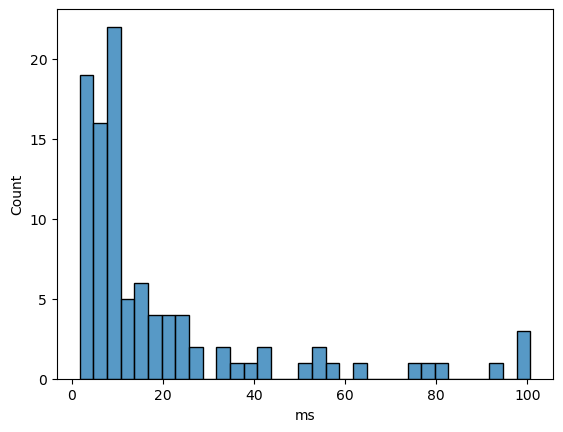

In [ ]:
with torch.no_grad():
    clipped = clip_tc(net.lif1.beta)
    tc_matrix = clipped.detach().numpy()
    print(tc_matrix)
    tau = (-time_step / np.log(tc_matrix)) / 1e-3
    ax = sns.histplot(tau, kde = False, binwidth = 3)
    plt.xlabel('ms')

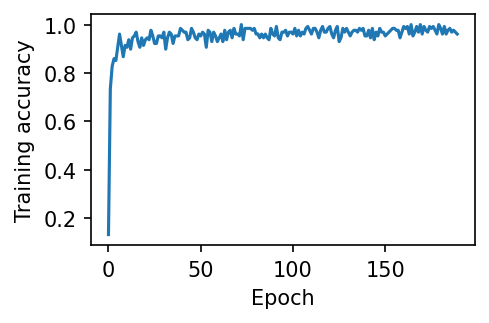

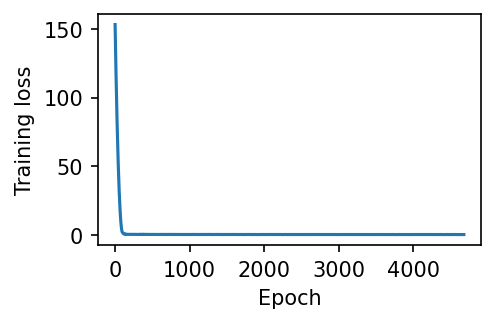

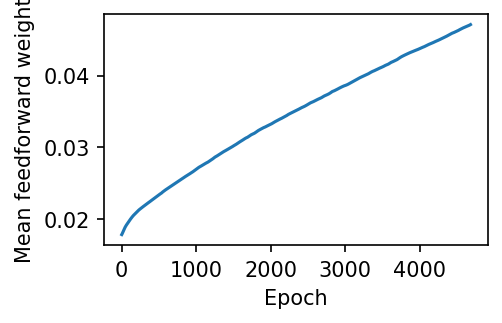

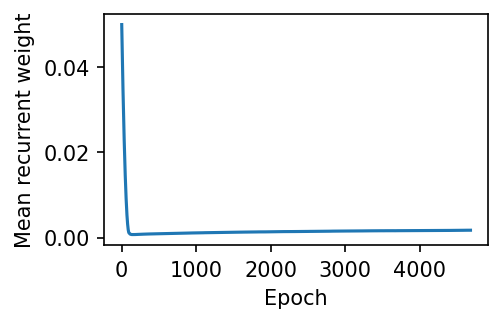

In [ ]:
#Data visualizations -----

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#Need to change the axis scales to reflect epochs!

#Accuracy/performance
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(acc_hist)
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.savefig('Training accuracy')

#Loss
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.savefig('Training loss')

#Mean feedforward weight
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(feed_mean_hist)
plt.xlabel('Epoch')
plt.ylabel('Mean feedforward weight')
plt.savefig('Mean feedforward weight') 

#Mean recurrent weight
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(rec_mean_hist)
plt.xlabel('Epoch')
plt.ylabel('Mean recurrent weight')
plt.savefig('Mean recurrent weight') 

In [ ]:
#Model summary -----

